In [1]:
import numpy as np
np.random.seed(12345)
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
from utils import get_NS_ONB
from sklearn.decomposition import PCA
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import FDataBasis, BSpline
from skfda.representation.grid import FDataGrid
from tqdm import tqdm

In [101]:
def get_Ghat(df, basis, return_xi=False):
    grid = FDataGrid(np.array(df))
    basis_grid = grid.to_basis(basis)
    xi = (basis_grid - basis_grid.mean()).coefficients
    if return_xi:
        return xi
    else:
        n = xi.shape[0]
        return np.dot(xi.T, xi)/n
    
    
def get_Sn_hat_and_zeta(df, basis, theta):
    Ghat = get_Ghat(df, basis)
    xi = get_Ghat(df, basis, return_xi=True)
    knots = np.linspace(0,1,30)
    dx = knots[1]

    psiONB = get_NS_ONB(theta)
    Z = np.zeros((3,3))
    zeta = []
    for k in range(3):
        for k_prime in range(3):
            if k < k_prime:
                Z[k, k_prime] = (np.dot(np.dot(np.expand_dims(psiONB[k](knots), axis=0), Ghat), 
                               np.expand_dims(psiONB[k_prime](knots), axis=1)) * dx**2)[0]   

        zeta.append(np.dot(xi, np.expand_dims(psiONB[k](knots), axis=1)) * dx)
        
    Z = np.triu(Z, k=1)
    Sn_hat = (Z ** 2).sum() * len(df)
    return Sn_hat, np.hstack(zeta)


def get_Sn_hat_and_zeta_fpca(df, basis, theta, fpca):
    Ghat = get_Ghat(df, basis)
    xi = get_Ghat(df, basis, return_xi=True)
    knots = np.linspace(0,1,30)
    dx = knots[1]
    fpc = fpca.components_.coefficients

    psiONB = get_NS_ONB(theta)
    Z = np.zeros((3,3))
    zeta = []
    for k in range(3):
        for k_prime in range(3):
            if k < k_prime:
                Z[k, k_prime] = (np.dot(np.dot(np.expand_dims(fpc[k], axis=0), Ghat), 
                               np.expand_dims(fpc[k_prime], axis=1)) * dx**2)[0]   

        zeta.append(np.dot(xi, np.expand_dims(fpc[k], axis=1)) * dx)
        
    # if not UT
    #Z = np.triu(Z, k=1)
    Sn_hat = (Z ** 2).sum() * len(df)
    return Sn_hat, fpca.transform(basis_grid)
    #return Sn_hat, np.hstack(zeta)

In [3]:
df = pd.read_csv('zcb.csv', index_col=0).dropna()
df.index = pd.to_datetime(df.index)
df.columns = [int(i[-2:]) for i in df.columns]
df['year'] = df.index.year

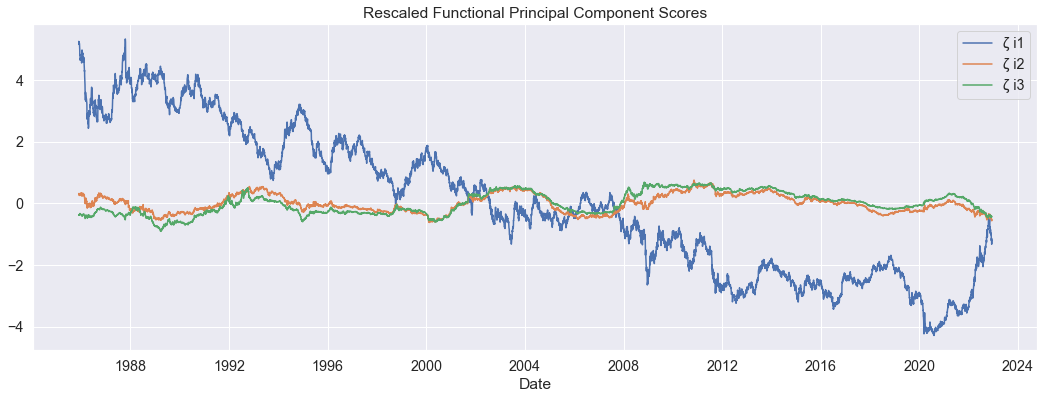

In [4]:
basis = BSpline(n_basis=30, order=3)
Sn_hat, zeta = get_Sn_hat_and_zeta(df.iloc[:,:-1], basis, theta=-0.1)

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df.index, zeta)
ax.set_xlabel('Date')
ax.set_title('Rescaled Functional Principal Component Scores')
ax.legend(['ζ i1','ζ i2','ζ i3']);
plt.savefig('zeta.pdf')

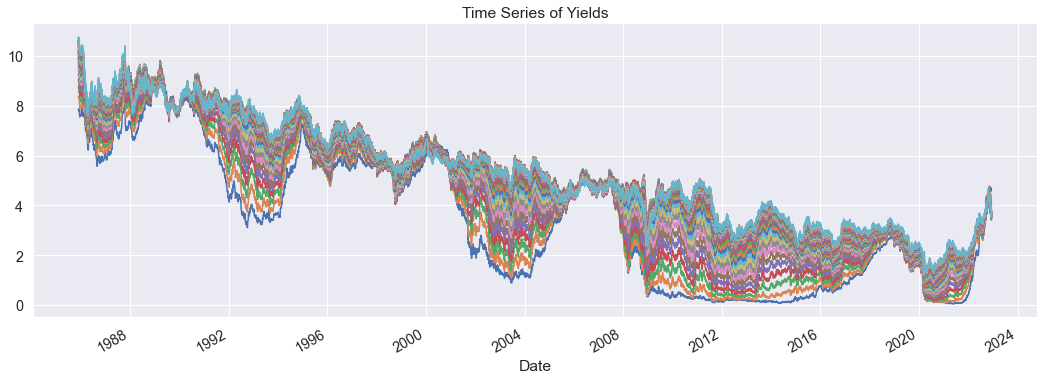

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
df.iloc[:,:-1].plot(ax=ax, legend=False)
ax.set_xlabel('Date')
ax.set_title('Time Series of Yields');
plt.savefig('timeSeriesYields.pdf')

In [156]:
def get_p_value_UT(Sn_hat, zeta, num_simu=1e4):
    n, kappa = zeta.shape
    lam = (zeta ** 2).mean(axis=0)
    outer_lam = np.triu(np.outer(lam, lam), k=1)

    Sn_bar = []
    for _ in range(int(num_simu)):
        chi2 = np.triu(st.chi2.rvs(df=1, size=(kappa, kappa)), k=1)
        Sn_bar.append((chi2 * outer_lam).sum())

    return sum([Sn_hat <= S for S in Sn_bar]) / num_simu, Sn_bar

In [133]:
def get_p_value(Sn_hat, zeta, df, num_simu=1e4):
    n, kappa = zeta.shape
    
    xi = get_Ghat(df.iloc[:,:-1], basis, return_xi=True) # n x N, assuming equal \xi_k
    Exi4 = max((xi**4 - 1).mean(), 0) # needs to be positive
    weight = Exi4 * np.eye(kappa) + np.ones((kappa,kappa)) - np.eye(kappa)
    
    lam = (zeta ** 2).mean(axis=0)
    outer_lam = np.outer(lam, lam)

    Sn_bar = []
    for _ in range(int(num_simu)):
        chi2 = st.chi2.rvs(df=1, size=(kappa, kappa))
        Sn_bar.append((chi2 * outer_lam * weight).sum())

    return sum([Sn_hat <= S for S in Sn_bar]) / num_simu, Sn_bar

## FPCA

In [5]:
fpca.explained_variance_

array([5.12545443e+00, 1.26404456e-01, 7.19196832e-03, 2.92689143e-03,
       3.75556649e-04])

In [77]:
Sn_hat, zeta = get_Sn_hat_and_zeta_fpca(df.iloc[:,:-1], basis, theta=0.1, fpca=fpca)
print((zeta ** 2).mean(axis=0))
p, Sn_bar = get_p_value_UT(Sn_hat, zeta)
p

[5.12490014e+00 1.26390786e-01 7.19119056e-03 2.92657491e-03
 3.75516035e-04]


100%|████████████████████████████████| 100000/100000 [00:05<00:00, 18514.94it/s]


0.0

In [70]:
Sn_hat

5477.366502934396

In [144]:
data = df.iloc[:,:-1]

for theta in theta_list:
    Sn_hat, zeta = get_Sn_hat_and_zeta(data, basis, theta=theta)
    p, Sn_bar = get_p_value(Sn_hat, zeta, data)
    print(p)

0.1944
0.1946
0.0932
0.0515
0.1925
0.1724
0.1506
0.0744
0.0169


In [157]:
data = df.iloc[:,:-1]

for theta in theta_list:
    Sn_hat, zeta = get_Sn_hat_and_zeta(data, basis, theta=theta)
    p, Sn_bar = get_p_value_UT(Sn_hat, zeta)
    print(p)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [153]:
Sn_hat

9436.866441476473

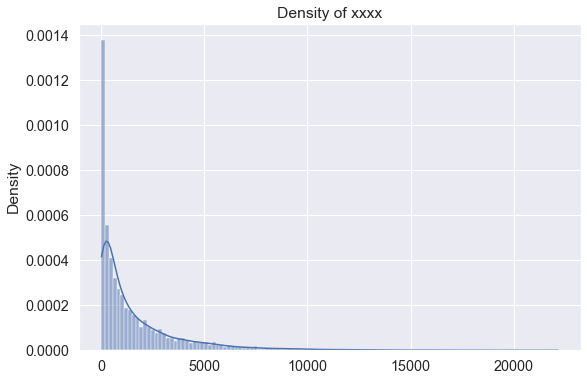

In [152]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.histplot(Sn_bar, kde=True, stat='density')
ax.set_title('Density of xxxx');

In [141]:
theta_list = [-0.1, -0.01, -0.001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
p_res = []
for year in tqdm(set(df['year'])):
    data = df[df['year']==year].iloc[:,:-1]
    p_list = []
    for theta in theta_list:
        Sn_hat, zeta = get_Sn_hat_and_zeta(data, basis, theta=theta)
        p, Sn_bar = get_p_value(Sn_hat, zeta, df.iloc[:,:-1]) # use all data to estimate Exi^4
        p_list.append(p)
    p_res.append(p_list)

100%|███████████████████████████████████████████| 38/38 [02:33<00:00,  4.05s/it]


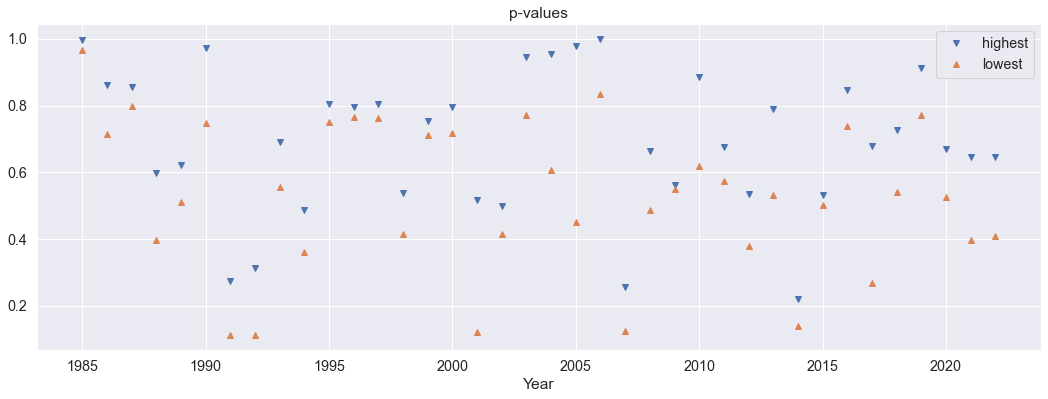

In [151]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(list(set(df['year'])), [max(p) for p in p_res], 'v', label='highest')
ax.plot(list(set(df['year'])), [min(p) for p in p_res], '^', label='lowest')
ax.set_xlabel('Year')
ax.set_title('p-values')
ax.legend();
plt.savefig('pvalues.pdf')

In [158]:
theta_list = [-0.1, -0.01, -0.001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
p_res = []
for year in tqdm(set(df['year'])):
    data = df[df['year']==year].iloc[:,:-1]
    p_list = []
    for theta in theta_list:
        Sn_hat, zeta = get_Sn_hat_and_zeta(data, basis, theta=theta)
        p, Sn_bar = get_p_value_UT(Sn_hat, zeta)
        p_list.append(p)
    p_res.append(p_list)

100%|███████████████████████████████████████████| 38/38 [03:02<00:00,  4.81s/it]


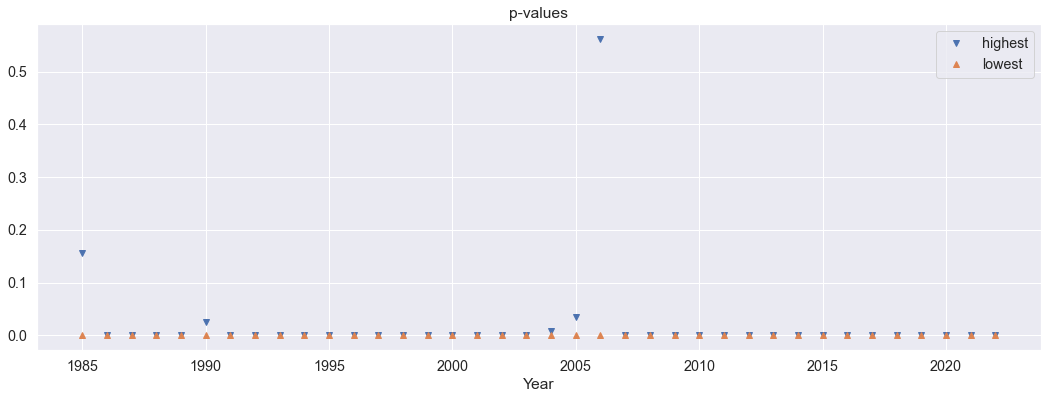

In [161]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(list(set(df['year'])), [max(p) for p in p_res], 'v', label='highest')
ax.plot(list(set(df['year'])), [min(p) for p in p_res], '^', label='lowest')
ax.set_xlabel('Year')
ax.set_title('p-values')
ax.legend();
#plt.yscale('log')
plt.savefig('pvalues_UT.pdf')

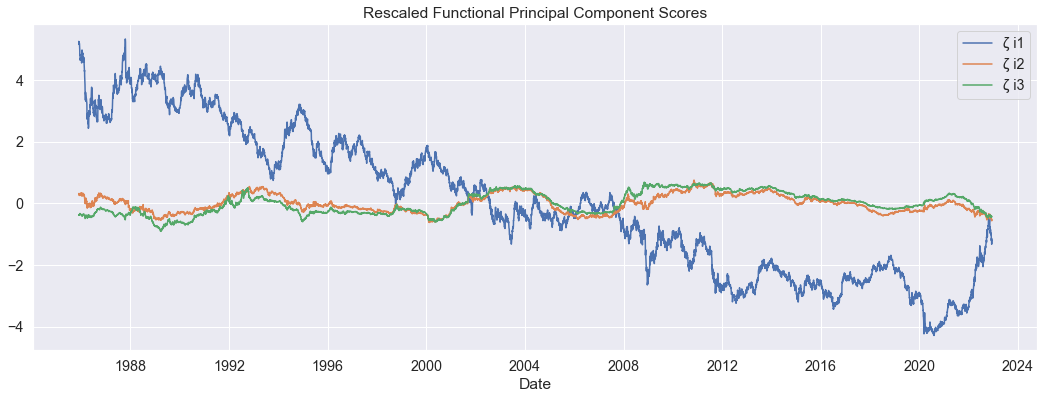

In [4]:
basis = BSpline(n_basis=30, order=3)
Sn_hat, zeta = get_Sn_hat_and_zeta(df.iloc[:,:-1], basis, theta=-0.1)

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df.index, zeta)
ax.set_xlabel('Date')
ax.set_title('Rescaled Functional Principal Component Scores')
ax.legend(['ζ i1','ζ i2','ζ i3']);
plt.savefig('zeta.pdf')

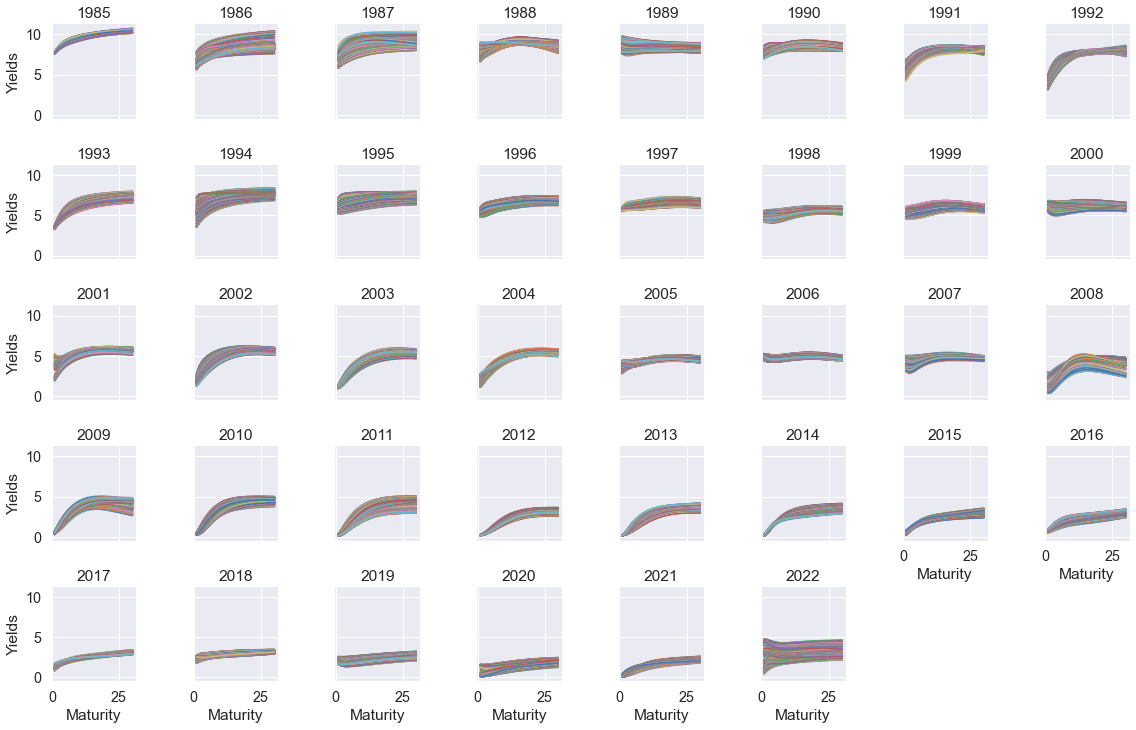

In [2]:
g = sns.FacetGrid(df, col="year", col_wrap=8, height=2)
for ax, year in zip(g.axes_dict.values(), set(df['year'])):
    df[df['year']==year].iloc[:,:-1].T.plot(legend=False, ax=ax)
    ax.set_title(year)
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Yields')
plt.savefig('yieldCurveYear.pdf')

[9.70585631e-01 2.70988094e-02 1.47458825e-03 7.27545001e-04
 1.03407304e-04]


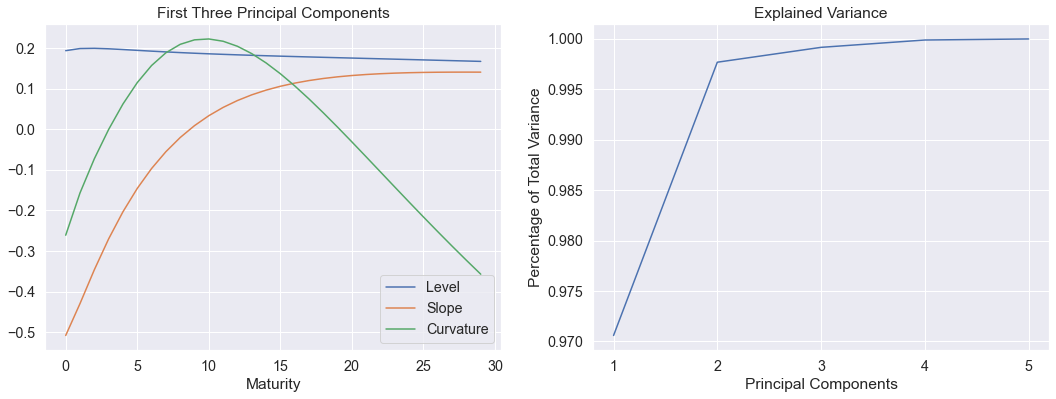

In [70]:
K = 5
pca = PCA(n_components=K, svd_solver='arpack')
pca.fit(np.array(df.iloc[:,:-1]))
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
ax[0].plot(pca.components_[:3,:].T, label=['Level', 'Slope', 'Curvature'])
ax[0].legend()
ax[0].set_xlabel('Maturity')
ax[0].set_title('First Three Principal Components')

ax[1].plot(range(1,K+1), pca.explained_variance_ratio_.cumsum())
ax[1].set_xticks(range(1,K+1))
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Percentage of Total Variance')
ax[1].set_title('Explained Variance');

plt.savefig('first3PC_allData.pdf')

[9.70585631e-01 2.70988094e-02 1.47458825e-03 7.27545001e-04
 1.03407304e-04 9.45701139e-06 5.02843131e-07]


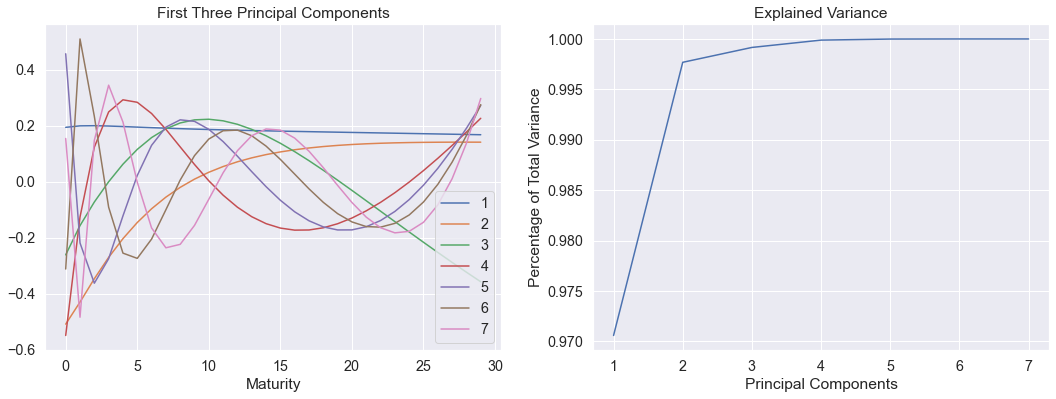

In [72]:
K = 7
pca = PCA(n_components=K, svd_solver='arpack')
pca.fit(np.array(df.iloc[:,:-1]))
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
ax[0].plot(pca.components_[:K,:].T, label=range(1,K+1))
ax[0].legend()
ax[0].set_xlabel('Maturity')
ax[0].set_title('First Three Principal Components')

ax[1].plot(range(1,K+1), pca.explained_variance_ratio_.cumsum())
ax[1].set_xticks(range(1,K+1))
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Percentage of Total Variance')
ax[1].set_title('Explained Variance');

#plt.savefig('first3PC_allData.pdf')

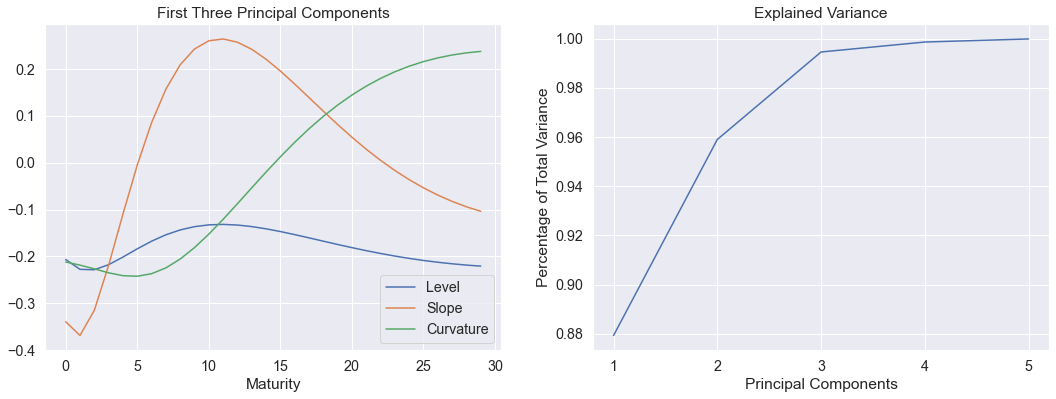

In [40]:
K = 5
pca = PCA(n_components=K, svd_solver='arpack')
pca.fit(np.array(df[df['year']==2008].iloc[:,:-1]))
#pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
ax[0].plot(pca.components_[:3,:].T, label=['Level', 'Slope', 'Curvature'])
ax[0].legend()
ax[0].set_xlabel('Maturity')
ax[0].set_title('First Three Principal Components')

ax[1].plot(range(1,K+1), pca.explained_variance_ratio_.cumsum())
ax[1].set_xticks(range(1,K+1))
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Percentage of Total Variance')
ax[1].set_title('Explained Variance');

#plt.savefig('first3PC_allData.pdf')

In [44]:
(pca.components_[0] * pca.components_[1]).sum()

-7.28583859910259e-17

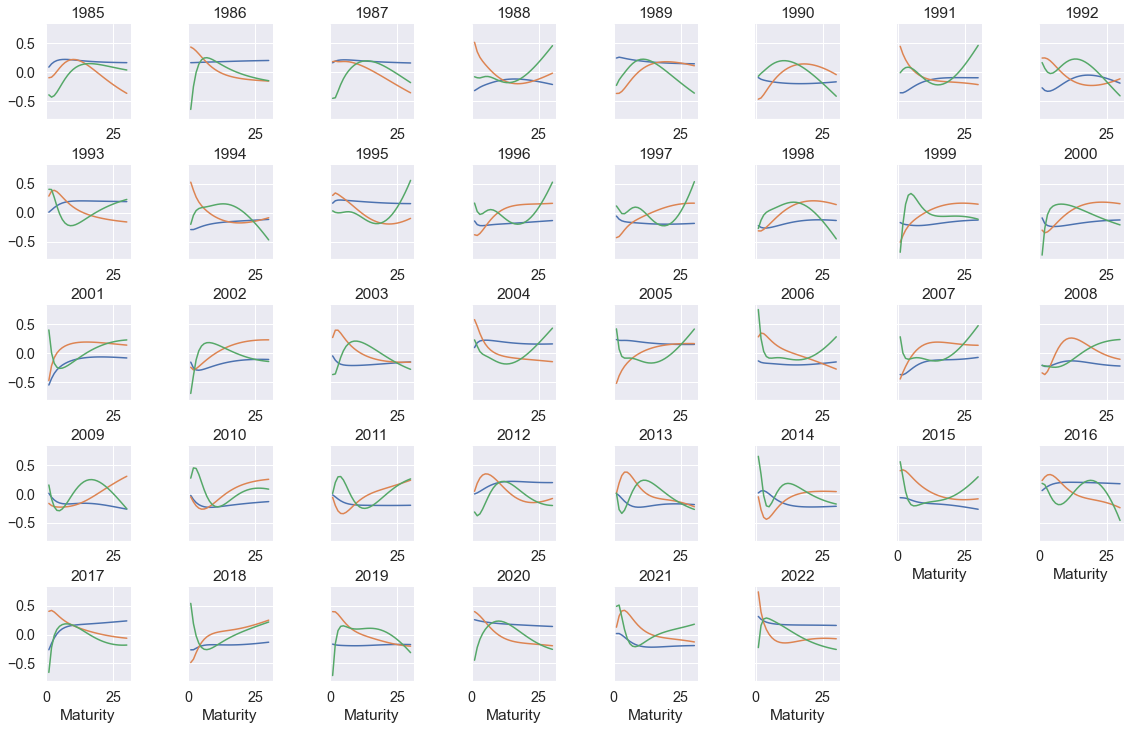

In [74]:
K = 3

var_ratio = []
curvatures = [] # to check the intersections with 0
g = sns.FacetGrid(df, col="year", col_wrap=8, height=2)
for ax, year in zip(g.axes_dict.values(), set(df['year'])):
    pca = PCA(n_components=K, svd_solver='arpack')
    pca.fit(np.array(df[df['year']==year].iloc[:,:-1]))
    var_ratio.append(pca.explained_variance_ratio_.cumsum())
    curvatures.append(pca.components_[-1])
    
    ax.plot(range(1,31), pca.components_[:3,:].T, label=['Level', 'Slope', 'Curvature'])
    ax.set_xlabel('Maturity')
    ax.set_title(year)
plt.savefig('first3PC_year.pdf')

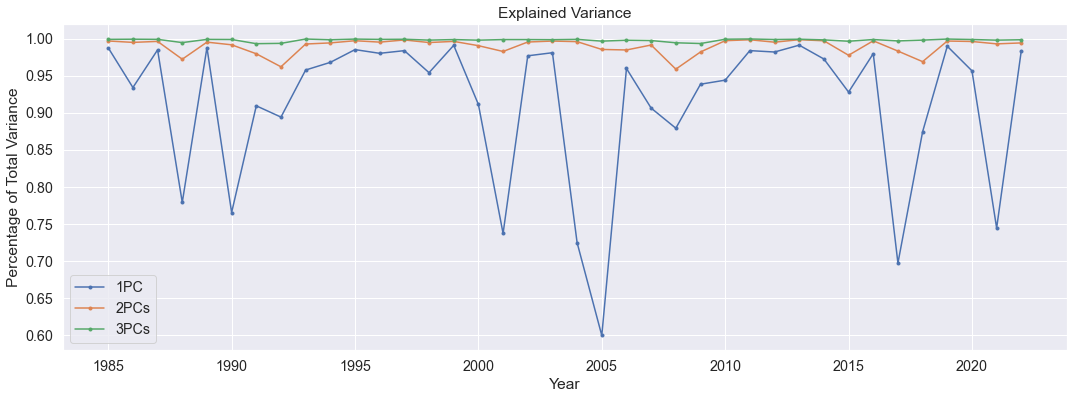

In [19]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(list(set(df['year'])), var_ratio, '.-' ,label=['1PC', '2PCs', '3PCs'])
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Total Variance')
ax.set_title('Explained Variance')
#plt.yscale('log')
plt.savefig('explainedVar.pdf')

In [86]:
(np.diff(np.sign(curvatures)) != 0).sum(axis=1) # sign changes are not always 2

array([1, 2, 2, 1, 2, 2, 3, 3, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2])

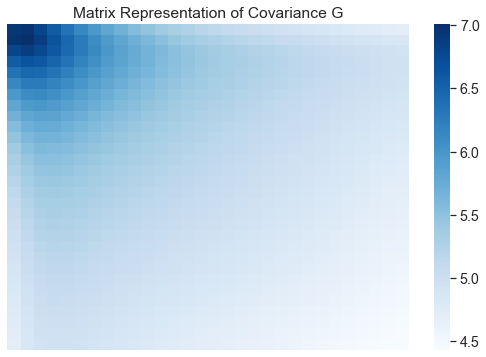

In [4]:
K = 5
basis = BSpline(n_basis=30, order=3)

fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(get_Ghat(df.iloc[:,:-1], basis), cmap='Blues', xticklabels=[], yticklabels=[], ax=ax)
ax.set_title('Matrix Representation of Covariance G');
plt.savefig('Ghat_all.pdf')

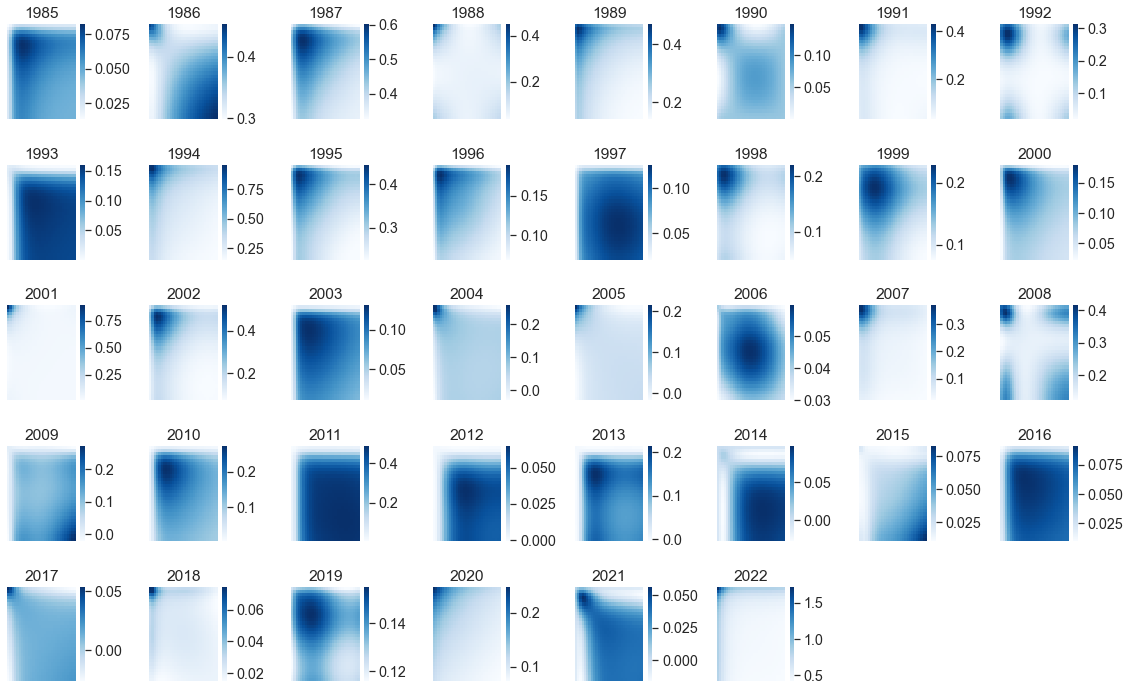

In [8]:
g = sns.FacetGrid(df, col="year", col_wrap=8, height=2)
for ax, year in zip(g.axes_dict.values(), set(df['year'])):
    sns.heatmap(get_Ghat(df[df['year']==year].iloc[:,:-1], BSpline(n_basis=30, order=3)), cmap='Blues', 
                xticklabels=[], yticklabels=[], ax=ax)
    ax.set_title(year)
plt.savefig('GhatYear.pdf')

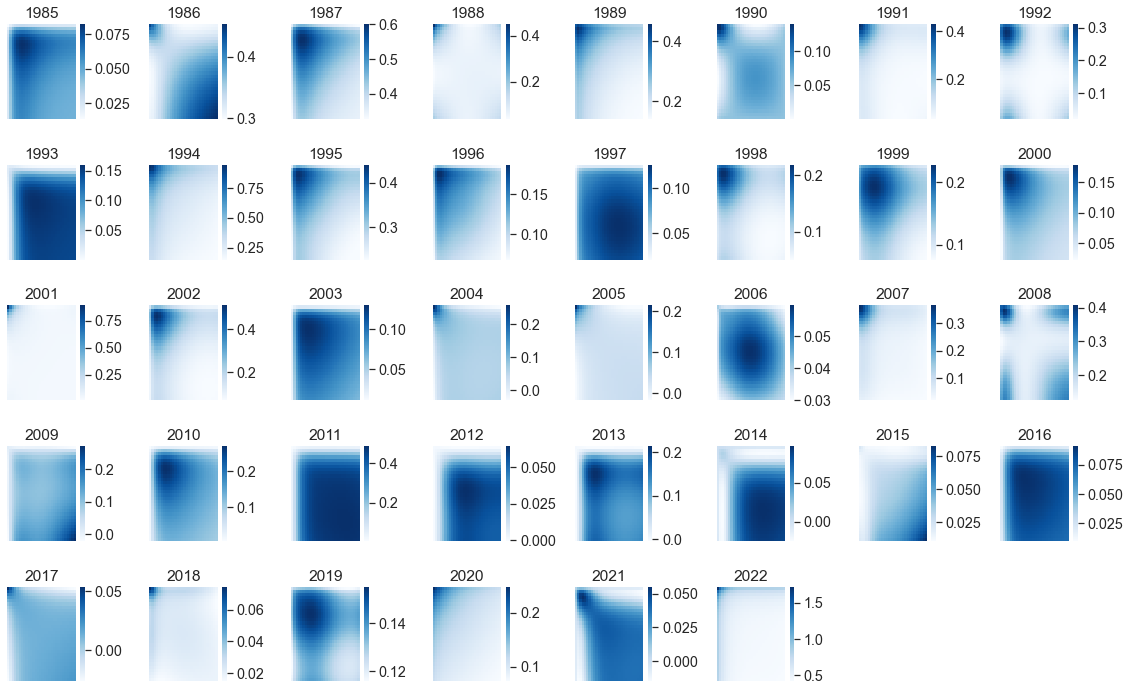

In [14]:
g = sns.FacetGrid(df, col="year", col_wrap=8, height=2)
for ax, year in zip(g.axes_dict.values(), set(df['year'])):
    sns.heatmap(get_Ghat(df[df['year']==year].iloc[:,:-1], BSpline(n_basis=30, order=1)), cmap='Blues', 
                xticklabels=[], yticklabels=[], ax=ax)
    ax.set_title(year)
plt.savefig('GhatYear_order1.pdf')

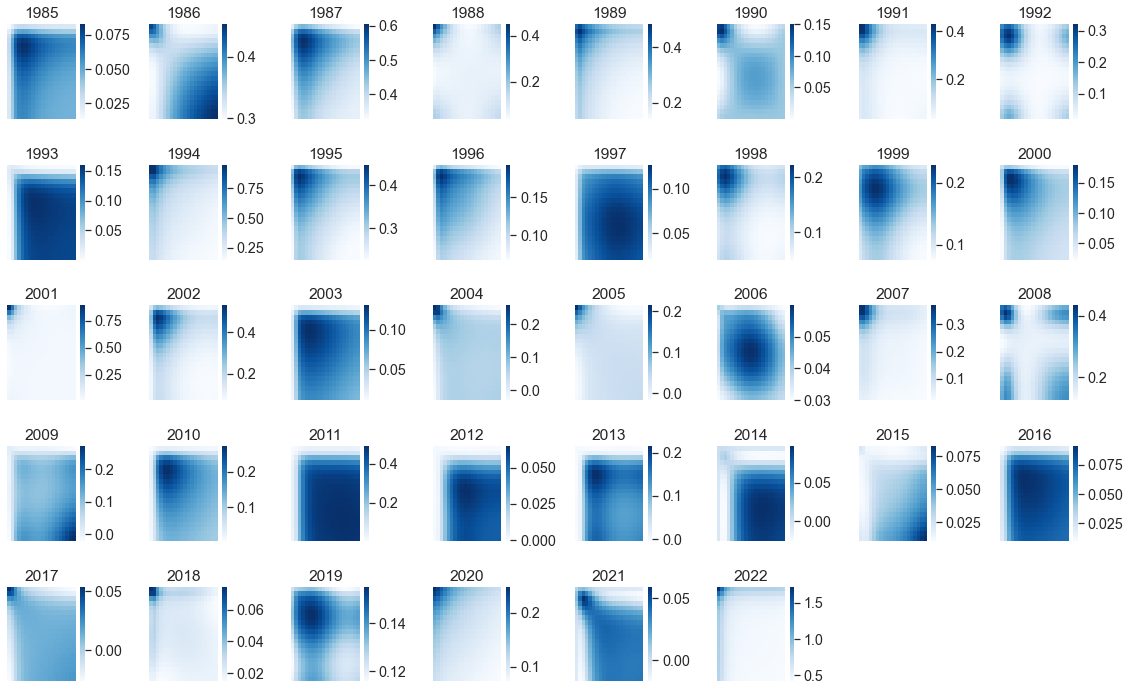

In [15]:
g = sns.FacetGrid(df, col="year", col_wrap=8, height=2)
for ax, year in zip(g.axes_dict.values(), set(df['year'])):
    sns.heatmap(get_Ghat(df[df['year']==year].iloc[:,:-1], BSpline(n_basis=20, order=3)), cmap='Blues', 
                xticklabels=[], yticklabels=[], ax=ax)
    ax.set_title(year)
plt.savefig('GhatYear_knots20.pdf')

## FPCA

[9.73978731e-01 2.40203582e-02 1.36667378e-03 5.56190683e-04
 7.13661966e-05]


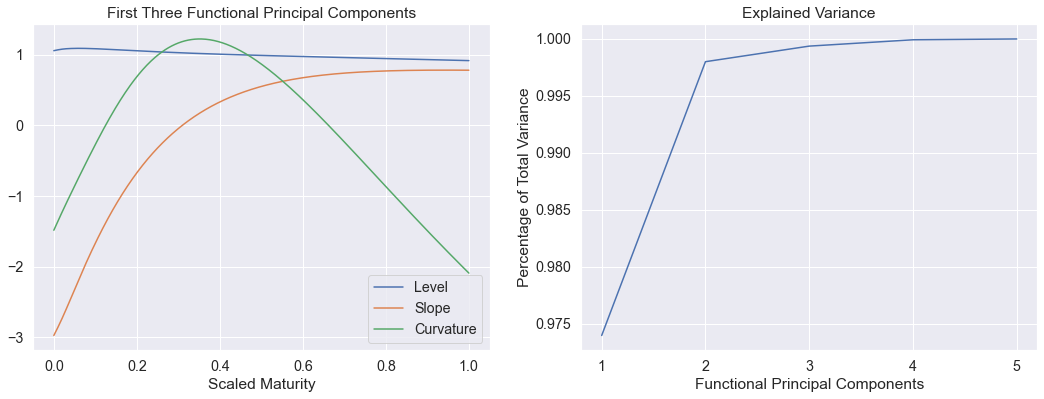

In [4]:
K = 5
basis = BSpline(n_basis=30, order=3) # order can be 1
grid = FDataGrid(np.array(df.iloc[:,:-1]))
basis_grid = grid.to_basis(basis)
    
fpca = FPCA(n_components=K)
fpca.fit(basis_grid)
print(fpca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
fpca.components_[:3].plot(axes=ax[0]);
#ax[0].plot(pca.components_[:3,:].T, )
ax[0].legend(['Level', 'Slope', 'Curvature'])
ax[0].set_xlabel('Scaled Maturity')
ax[0].set_title('First Three Functional Principal Components')

ax[1].plot(range(1,K+1), fpca.explained_variance_ratio_.cumsum())
ax[1].set_xticks(range(1,K+1))
ax[1].set_xlabel('Functional Principal Components')
ax[1].set_ylabel('Percentage of Total Variance')
ax[1].set_title('Explained Variance');

plt.savefig('first3FPC_allData.pdf')

In [53]:
(fpca.components_.coefficients[0] * fpca.components_.coefficients[1]).sum() / 30 # not exactly orthogonal

-0.0795799494292582

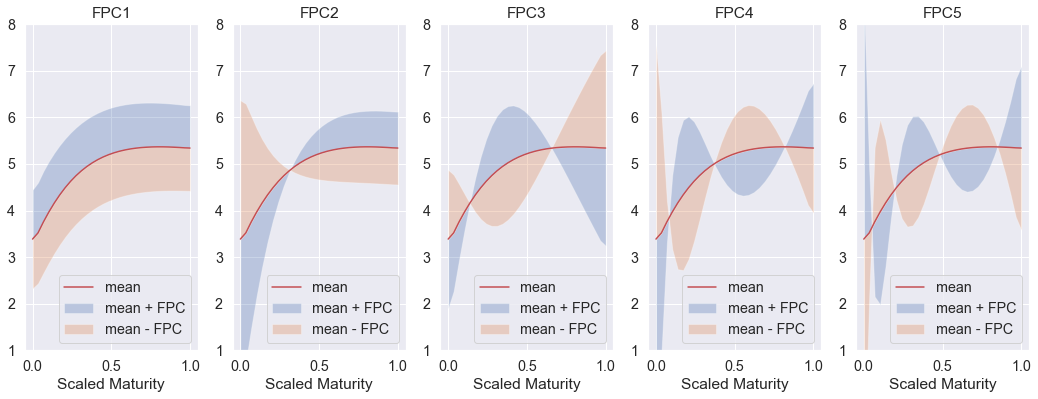

In [68]:
m = basis_grid.mean().coefficients[0]
add = m + fpca.components_.coefficients
sub = m - fpca.components_.coefficients
x = np.linspace(0,1,30)

fig, ax = plt.subplots(figsize=(18,6), ncols=K)
for i in range(K):
    ax[i].plot(x, m, 'r', label='mean')
    ax[i].fill_between(x, m, add[i], alpha=.3, label='mean + FPC')
    ax[i].fill_between(x, m, sub[i], alpha=.3, label='mean - FPC')
    ax[i].set_ylim(1,8)
    ax[i].set_xlabel('Scaled Maturity')
    ax[i].set_title('FPC'+str(i+1))
    ax[i].legend(loc='lower right')
plt.savefig('FPC_effects.pdf')

[9.70585631e-01 2.70988094e-02 1.47458825e-03 7.27545001e-04
 1.03407304e-04]


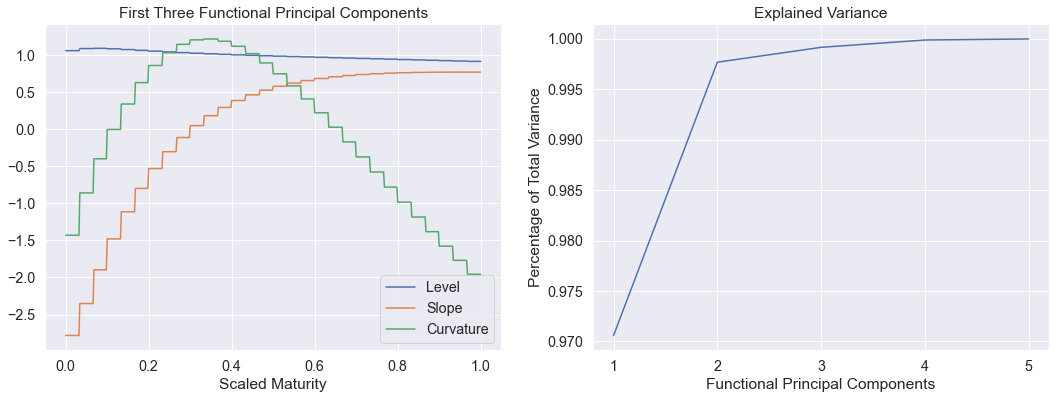

In [91]:
K = 5
basis = BSpline(n_basis=30, order=1)
grid = FDataGrid(np.array(df.iloc[:,:-1]))
basis_grid = grid.to_basis(basis)
    
fpca = FPCA(n_components=K)
fpca.fit(basis_grid)
print(fpca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
fpca.components_[:3].plot(axes=ax[0]);
#ax[0].plot(pca.components_[:3,:].T, )
ax[0].legend(['Level', 'Slope', 'Curvature'])
ax[0].set_xlabel('Scaled Maturity')
ax[0].set_title('First Three Functional Principal Components')

ax[1].plot(range(1,K+1), fpca.explained_variance_ratio_.cumsum())
ax[1].set_xticks(range(1,K+1))
ax[1].set_xlabel('Functional Principal Components')
ax[1].set_ylabel('Percentage of Total Variance')
ax[1].set_title('Explained Variance');

plt.savefig('first3FPC_allData_linear.pdf')

[0.8825614  0.07878971 0.03552204 0.00198738 0.00105259]


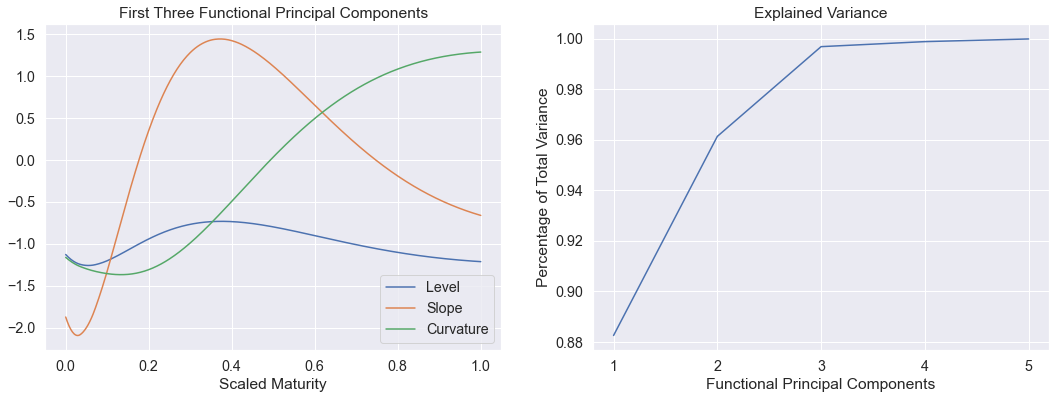

In [93]:
K = 5
basis = BSpline(n_basis=30, order=3) # order can be 1
grid = FDataGrid(np.array(df[df['year']==2008].iloc[:,:-1]))
basis_grid = grid.to_basis(basis)
    
fpca = FPCA(n_components=K)
fpca.fit(basis_grid)
print(fpca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
fpca.components_[:3].plot(axes=ax[0]);
#ax[0].plot(pca.components_[:3,:].T, )
ax[0].legend(['Level', 'Slope', 'Curvature'])
ax[0].set_xlabel('Scaled Maturity')
ax[0].set_title('First Three Functional Principal Components')

ax[1].plot(range(1,K+1), fpca.explained_variance_ratio_.cumsum())
ax[1].set_xticks(range(1,K+1))
ax[1].set_xlabel('Functional Principal Components')
ax[1].set_ylabel('Percentage of Total Variance')
ax[1].set_title('Explained Variance');

plt.savefig('first3FPC_allData_2008.pdf')

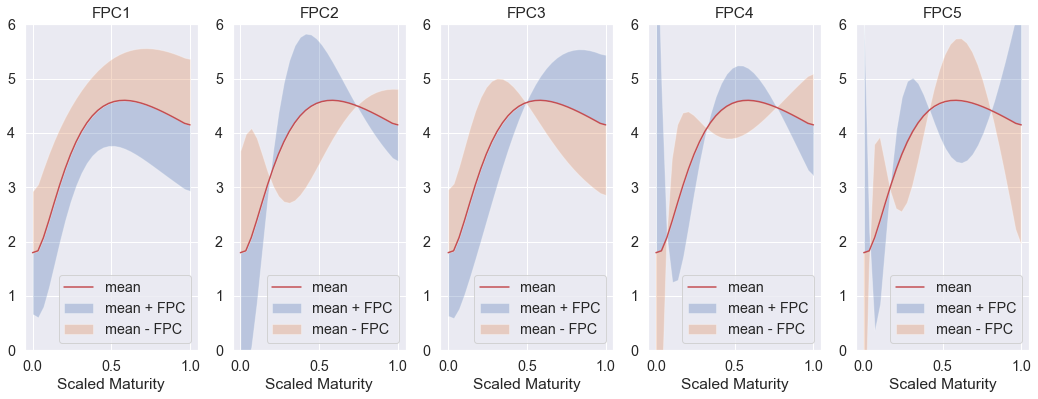

In [94]:
m = basis_grid.mean().coefficients[0]
add = m + fpca.components_.coefficients
sub = m - fpca.components_.coefficients
x = np.linspace(0,1,30)

fig, ax = plt.subplots(figsize=(18,6), ncols=K)
for i in range(K):
    ax[i].plot(x, m, 'r', label='mean')
    ax[i].fill_between(x, m, add[i], alpha=.3, label='mean + FPC')
    ax[i].fill_between(x, m, sub[i], alpha=.3, label='mean - FPC')
    ax[i].set_ylim(0,6)
    ax[i].set_xlabel('Scaled Maturity')
    ax[i].set_title('FPC'+str(i+1))
    ax[i].legend(loc='lower right')
plt.savefig('FPC_effects_2008.pdf')

In [5]:
params = pd.read_csv('params.csv', index_col=0).dropna()
params = params[params['TAU2']!=-999.99]
params.index = pd.to_datetime(params.index)
#df.columns = [int(i[-2:]) for i in df.columns]
params['year'] = params.index.year

<AxesSubplot:xlabel='Date'>

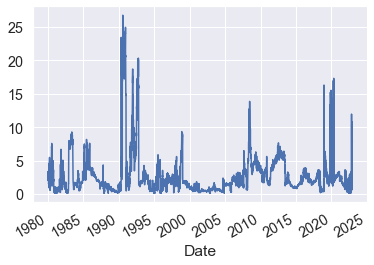

In [10]:
params['TAU1'].plot()

<AxesSubplot:xlabel='Date'>

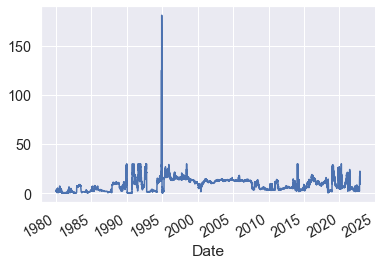

In [11]:
params['TAU2'].plot()

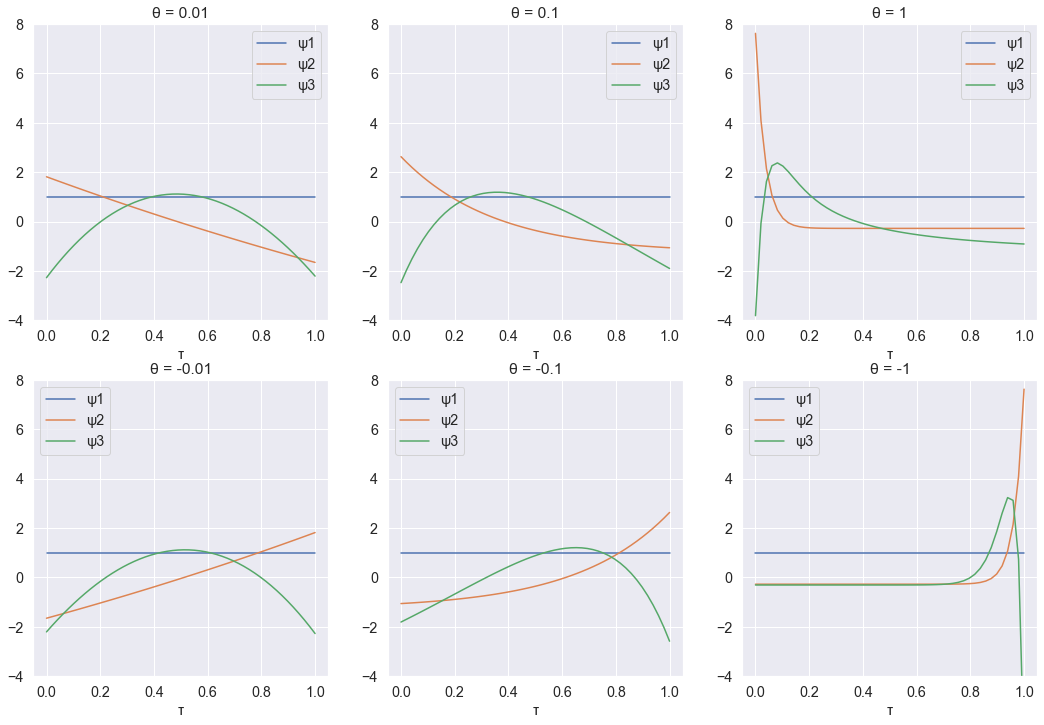

In [32]:
tau_tilde = np.linspace(0,1)
fig, ax = plt.subplots(figsize=(18,12), nrows=2, ncols=3)
for i, theta in enumerate([0.01, 0.1, 1]):
    for k, onb in enumerate(get_NS_ONB(theta)):
        ax[0][i].plot(tau_tilde, onb(tau_tilde), label='ψ'+str(k+1))
    ax[0][i].set_ylim(-4,8)
    ax[0][i].set_xlabel('τ')
    ax[0][i].set_title(f'θ = {theta}')
    ax[0][i].legend()
    for k, onb in enumerate(get_NS_ONB(-theta)):
        ax[1][i].plot(tau_tilde, onb(tau_tilde), label='ψ'+str(k+1))
    ax[1][i].set_ylim(-4,8)
    ax[1][i].set_xlabel('τ')
    ax[1][i].set_title(f'θ = {-theta}')
    ax[1][i].legend(loc='upper left')

plt.savefig('NS_ONB.pdf')